# PyEumap - Land Cover Mapping (Advanced)

In this tutorial we improve the land cover mapping through a hyperparameter optimization and present some alternative to produce probability outputs using the eumap library. Before continue, please, first execute the [Overlay Demonstration](02_overlay.ipynb) and [Land-Cover Mapping](03_landcover_mapping.ipynb) tutorials for the same tile.

First, let's import the necessary modules

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

...and load the overlaid samples for a specific tile:

In [2]:
from pyeumap import datasets

# Tile definition
tile = datasets.TILES[0]
print(f'Tile: {tile}\n\n')

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points.head()

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_winter_green_p75,landsat_ard_spring_green_p75,...,landsat_ard_summer_thermal_p75,landsat_ard_winter_thermal_p50,landsat_ard_winter_blue_p25,landsat_ard_fall_thermal_p50,landsat_ard_summer_thermal_p50,landsat_ard_spring_blue_p50,landsat_ard_fall_blue_p25,landsat_ard_spring_blue_p25,landsat_ard_summer_blue_p50,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,148.0,19.0,...,183.0,176.0,128.0,185.0,183.0,11.0,5.0,11.0,8.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,135.0,159.0,...,182.0,176.0,118.0,183.0,182.0,120.0,5.0,96.0,5.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,142.0,19.0,...,185.0,179.0,100.0,187.0,185.0,10.0,4.0,10.0,9.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,47.0,36.0,...,179.0,175.0,48.0,179.0,179.0,37.0,7.0,37.0,2.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,233.0,221.0,...,188.0,178.0,228.0,188.0,188.0,201.0,16.0,184.0,16.0,POINT (4156286.754 2595790.720)


## Soft Classification

For a soft classification the hyperparameter optimization should use a diferent evaluation metric, appropiate for probabilities output per class. For this tutorial we choosen [log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss). 

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by -1 the final error.

In [3]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

We will use the same classification algorithm, hyperparameter possibilities and cv strategy:

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'min_samples_leaf': [1, 5],
     'max_depth': [5, None], 
     'max_features': [0.5]
    }
)

Now let's create a new instance for the LandMapper class passing one aditional parameter:
* ***pred_method***: The predict_proba will change the model output for a lc-class probabilities.

In [5]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 5

landmapper_prob = LandMapper(points=points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = estimator, 
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        pred_method='predict_proba',
                        weight_col=weight_col,
                        verbose = True)

[17:05:25] Removing 74 samples due min_samples_per_class condition (< 0.05)
[17:05:25] Transforming lc_class:
[17:05:25]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[17:05:25]  -Transformed classes: [0 1 2 3 4 5 6 7]


Let's run it again.

**If it's taking too long try to reduce the hyperparameters possibilities and/or the k-fold cv (2-fold).**

In [6]:
landmapper_prob.train()

[17:05:25] Optimizing hyperparameters for RandomForestClassifier
[17:05:50]  1.07192 (+/-0.13580) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1}
[17:05:50]  1.05204 (+/-0.07097) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5}
[17:05:50]  0.84056 (+/-0.21061) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[17:05:50]  0.86881 (+/-0.06980) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 5}
[17:05:50] Best: -0.84056 using {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[17:05:50] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:05:59] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished


Now let's take a look in the classification report.

In [7]:
landmapper_prob.eval_metrics

{'log_loss': 0.7955693137647866}

In [8]:
print(f'Log loss: {landmapper_prob.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_prob.eval_report)

Log loss: 0.796


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8362     0.8422   0.3400        0.7424              0.7424         66
1  0.6225     0.8084   0.4300        0.7337              0.7300         199
2  1.0061     0.7935   0.3700        0.7651              0.7515         166
3  1.2564     0.5563   0.2900        0.5948              0.5798         116
4  1.5906     0.3793   0.2600        0.4167              0.3977         84
5  0.7164     0.7976   0.3700        0.7723              0.7723         101
6  0.5431     0.8831   0.4200        0.8035              0.8035         229
7  0.1481     0.9771   0.5151        0.9663              0.9663         89

Total                                                                     1050



Let's understand this report.

Using the cv result the LandMapper calculated the [log_loss]() and the pr_auc [(area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve) for each class. The pr_auc information was used to choosen the best probability value to derive a hard classification output, balancing the precision (producer's accuracy or the class understimation) and recall (user's accuracy or the class overestimation), thus minimizing the bias in the land-cover area estimation using the final maps. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the prob_metrics property

In [9]:
list(landmapper_prob.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

...and it's possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [10]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probabilty values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper_prob.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper_prob.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 2.493%
 - 1: 6.986%
 - 2: 6.569%
 - 3: 6.685%
 - 4: 5.983%
 - 5: 3.626%
 - 6: 6.536%
 - 7: 0.706%


# EML (Emsemble Machine Learning) and uncertanties

Random Forest

In [11]:
estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=85)

hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    param_grid = {
     'max_depth': [5, None], 
     'max_features': [0.5, None]
    }
)

XGBoost

In [12]:
import xgboost as xgb
estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    param_grid = {
     'eta': [0.001, 0.9], 
     'alpha': [0, 10]
    }
)

KerasClassifier

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from pyeumap.misc import build_ann

input_shape = 87
n_classes = 8
estimator_ann = Pipeline([
	('standardize', StandardScaler()),
	('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
		epochs=5, batch_size=64, learning_rate = 0.0005, \
		dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    param_grid = {
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

Metalearner

In [14]:
from sklearn.linear_model import LogisticRegression

meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial')

hyperpar_meta = GridSearchCV(
    estimator = meta_estimator,
    scoring = log_loss_scorer,
    param_grid = {
        'fit_intercept': [False, True],
        'C': [0.5, 1]
    }
)

Train

In [15]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

estimator_list = [estimator_rf, estimator_bgtree, estimator_ann]
hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann]

landmapper = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator_list = estimator_list, 
                        meta_estimator = meta_estimator,
                        hyperpar_selection_list = hyperpar_selection_list,
                        hyperpar_selection_meta = hyperpar_meta,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        verbose = True)

[17:06:02] Removing 74 samples due min_samples_per_class condition (< 0.05)
[17:06:02] Transforming lc_class:
[17:06:02]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[17:06:02]  -Transformed classes: [0 1 2 3 4 5 6 7]


In [16]:
landmapper.train()

[17:06:02] Optimizing hyperparameters for RandomForestClassifier
[17:06:06]  1.04163 (+/-0.00968) from {'max_depth': 5, 'max_features': 0.5}
[17:06:06]  1.04915 (+/-0.06431) from {'max_depth': 5, 'max_features': None}
[17:06:06]  0.84879 (+/-0.07771) from {'max_depth': None, 'max_features': 0.5}
[17:06:06]  0.91976 (+/-0.25546) from {'max_depth': None, 'max_features': None}
[17:06:06] Best: -0.84879 using {'max_depth': None, 'max_features': 0.5}
[17:06:06] Optimizing hyperparameters for XGBClassifier
[17:06:14]  2.03738 (+/-0.00082) from {'alpha': 0, 'eta': 0.001}
[17:06:14]  1.03860 (+/-0.21113) from {'alpha': 0, 'eta': 0.9}
[17:06:14]  2.05204 (+/-0.00138) from {'alpha': 10, 'eta': 0.001}
[17:06:14]  1.17280 (+/-0.05478) from {'alpha': 10, 'eta': 0.9}
[17:06:14] Best: -1.03860 using {'alpha': 0, 'eta': 0.9}
[17:06:14] Optimizing hyperparameters for Pipeline
[17:06:49]  1.72959 (+/-0.03339) from {'estimator__dropout_rate': 0, 'estimator__n_layers': 2}
[17:06:49]  1.93475 (+/-0.00091) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:06:58]  Meta-features shape: (1050, 24)
[17:06:58] Optimizing hyperparameters for LogisticRegression


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s finished


[17:06:58]  0.88748 (+/-0.05959) from {'C': 0.5, 'fit_intercept': False}
[17:06:58]  0.88658 (+/-0.05642) from {'C': 0.5, 'fit_intercept': True}
[17:06:58]  0.86867 (+/-0.06351) from {'C': 1, 'fit_intercept': False}
[17:06:58]  0.86817 (+/-0.06100) from {'C': 1, 'fit_intercept': True}
[17:06:58] Best: -0.86817 using {'C': 1, 'fit_intercept': True}
[17:06:58] Calculating evaluation metrics
[17:06:58] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


[17:06:59] Training XGBClassifier using all samples
[17:06:59] Training Pipeline using all samples
[17:07:03] Training meta-estimator using all samples


In [17]:
print(f'Log loss: {landmapper.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper.eval_report)

Log loss: 0.868


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.9782     0.7927   0.2816        0.7576              0.7576         66
1  0.7763     0.7694   0.4623        0.6935              0.6935         199
2  0.8951     0.7507   0.3490        0.7169              0.7169         166
3  1.5170     0.4552   0.2383        0.4914              0.4914         116
4  1.7671     0.2723   0.2456        0.3452              0.3452         84
5  0.7674     0.7908   0.3509        0.7723              0.7723         101
6  0.5170     0.8877   0.4106        0.8079              0.8079         229
7  0.2658     0.9762   0.4879        0.9326              0.9326         89

Total                                                                     1050



In [18]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_2000.tif')

output_fn_files = landmapper.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[17:07:03] Reading 87 raster files
[17:07:10] Executing RandomForestClassifier
[17:07:14] RandomForestClassifier prediction time: 3.56 segs
[17:07:14] Executing XGBClassifier
[17:07:16] XGBClassifier prediction time: 2.07 segs
[17:07:16] Executing Pipeline
[17:07:16] batch_size=500000
[17:07:20] Pipeline prediction time: 4.02 segs
[17:07:20] Executing LogisticRegression
[17:07:22] LogisticRegression prediction time: 1.94 segs
Output files:
 - land_cover_2000_b1.tif
 - land_cover_2000_b2.tif
 - land_cover_2000_b3.tif
 - land_cover_2000_b4.tif
 - land_cover_2000_b5.tif
 - land_cover_2000_b6.tif
 - land_cover_2000_b7.tif
 - land_cover_2000_b8.tif
 - land_cover_2000_hcl.tif
 - land_cover_2000_hcl_prob.tif
 - land_cover_2000_hcl_uncertainty.tif
 - land_cover_2000_uncertainty_b1.tif
 - land_cover_2000_uncertainty_b2.tif
 - land_cover_2000_uncertainty_b3.tif
 - land_cover_2000_uncertainty_b4.tif
 - land_cover_2000_uncertainty_b5.tif
 - land_cover_2000_uncertainty_b6.tif
 - land_cover_2000_unc

In [19]:
labels = [
    '231: Pastures',
    '312: Coniferous forest',
    '321: Natural grasslands',
    '322: Moors and heathland',
    '324: Transitional woodland-shrub',
    '332: Bare rocks',
    '333: Sparsely vegetated areas',
    '335: Glaciers and perpetual snow'
]

print("Land cover classes")
pd.DataFrame({
    'Label':labels,
    'Original': landmapper.target_classes['original'],
    'Transformed': landmapper.target_classes['transformed']
})

Land cover classes


,Label,Original,Transformed
0,231: Pastures,231.0,0
1,312: Coniferous forest,312.0,1
2,321: Natural grasslands,321.0,2
3,322: Moors and heathland,322.0,3
4,324: Transitional woodland-shrub,324.0,4
5,332: Bare rocks,332.0,5
6,333: Sparsely vegetated areas,333.0,6
7,335: Glaciers and perpetual snow,335.0,7


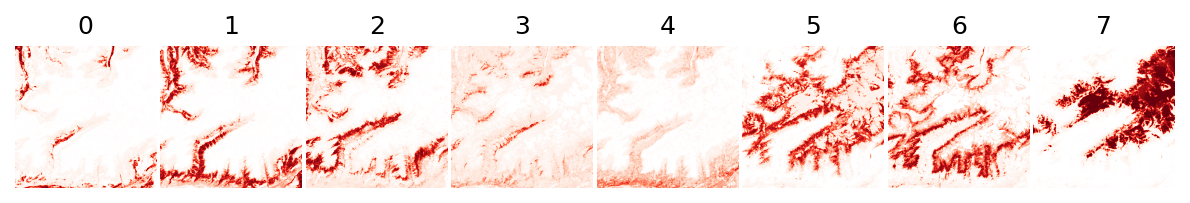

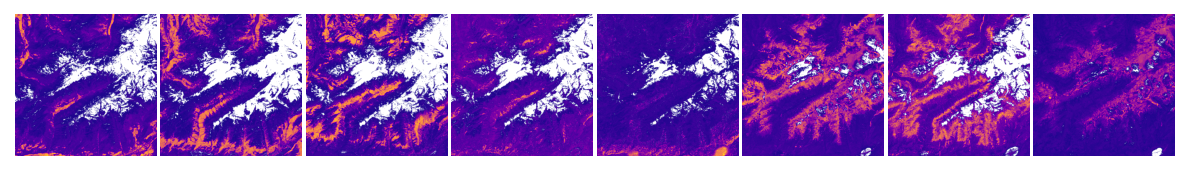

In [20]:
import numpy as np
from pyeumap.plotter import plot_rasters

lc_classes = [ int(c) for c in landmapper.target_classes['transformed']]

plot_rasters(*output_fn_files[0:8], cmaps='Reds', titles=lc_classes)
plot_rasters(*output_fn_files[11:19], cmaps='plasma')

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


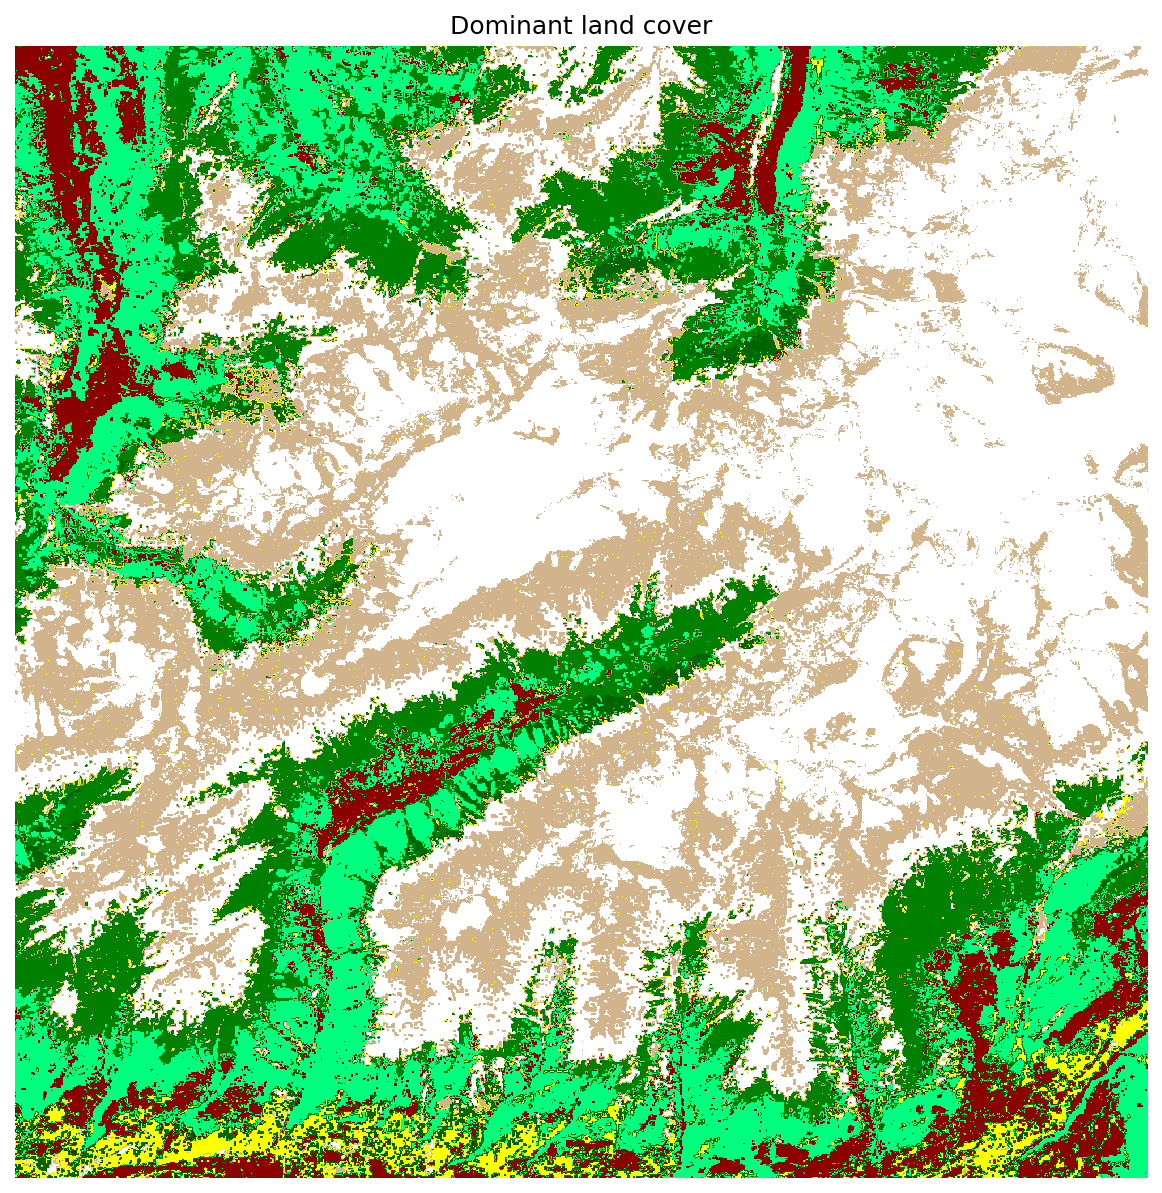

In [63]:
from pyeumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover')

In [22]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 

dirs_layers_list = []
fn_output_list = []

for year in range(2000, 2003):
    dir_time_layers = os.path.join(data_dir, str(year))
    dirs_layers = [dir_time_layers, dir_timeless_layers]
    fn_result = os.path.join(data_dir, f'land_cover_{year}.tif')
    
    dirs_layers_list.append(dirs_layers)
    fn_output_list.append(fn_result)

output_fn_files = landmapper.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[17:07:27] Reading 87 raster files
[17:07:33] 1) Reading time: 5.27 segs
[17:07:33] 1) Predicting 1000000 pixels[17:07:33] Reading 87 raster files

[17:07:33] Executing RandomForestClassifier
[17:07:37] RandomForestClassifier prediction time: 3.69 segs
[17:07:37] Executing XGBClassifier
[17:07:39] XGBClassifier prediction time: 2.27 segs
[17:07:39] Executing Pipeline
[17:07:39] batch_size=500000
[17:07:39] 2) Reading time: 6.60 segs
[17:07:39] Reading 87 raster files
[17:07:43] Pipeline prediction time: 4.02 segs
[17:07:43] Executing LogisticRegression
[17:07:44] LogisticRegression prediction time: 1.23 segs
[17:07:44] 1) Predicting time: 11.25 segs
[17:07:45] 2) Predicting 1000000 pixels
[17:07:45] Executing RandomForestClassifier
[17:07:45] 3) Reading time: 5.91 segs
[17:07:45] 1) Saving time: 0.81 segs
[17:07:48] RandomForestClassifier prediction time: 3.16 segs
[17:07:48] Executing XGBClassifier
[17:07:50] XGBClassifier prediction time: 1.61 segs
[17:07:50] Executing Pipeline
[17:0

## Scikit-learn pipeline

Now we will construct a stacked classifier ensemble using [`ml-ens`](http://ml-ensemble.com/) and train it on our data in an equivalent manner to training a single model.

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

In [2]:
from pyeumap import datasets

# Tile definition
tile = datasets.TILES[0]
print(f'Tile: {tile}\n\n')

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points.head()

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_winter_green_p75,landsat_ard_spring_green_p75,...,landsat_ard_summer_thermal_p75,landsat_ard_winter_thermal_p50,landsat_ard_winter_blue_p25,landsat_ard_fall_thermal_p50,landsat_ard_summer_thermal_p50,landsat_ard_spring_blue_p50,landsat_ard_fall_blue_p25,landsat_ard_spring_blue_p25,landsat_ard_summer_blue_p50,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,148.0,19.0,...,183.0,176.0,128.0,185.0,183.0,11.0,5.0,11.0,8.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,135.0,159.0,...,182.0,176.0,118.0,183.0,182.0,120.0,5.0,96.0,5.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,142.0,19.0,...,185.0,179.0,100.0,187.0,185.0,10.0,4.0,10.0,9.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,47.0,36.0,...,179.0,175.0,48.0,179.0,179.0,37.0,7.0,37.0,2.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,233.0,221.0,...,188.0,178.0,228.0,188.0,188.0,201.0,16.0,184.0,16.0,POINT (4156286.754 2595790.720)


In [44]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

In [51]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from pyeumap.misc import build_ann
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector

estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=85)

estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')

stacking_estimator = VotingClassifier(
     estimators = [
        ('rf', estimator_rf),
        ('xbgtree', estimator_bgtree),
    ], 
    voting='soft'
)

hyperpar_stacking = GridSearchCV(
    estimator = stacking_estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'xbgtree__eta': [0.001, 0.9], 
     'xbgtree__alpha': [0, 10],
     'rf__max_depth': [5, None], 
     'rf__max_features': [0.5, None]
    }
)

pipeline_estimator = Pipeline([
    ('hp', hyperpar_stacking),
    ('hp', hyperpar_stacking),
    ('estimator', stacking_estimator)
])

In [65]:
from sklearn import set_config
set_config(display='diagram')   
pipeline_estimator

Pipeline(steps=[('hp',
                 GridSearchCV(estimator=VotingClassifier(estimators=[('rf',
                                                                      RandomForestClassifier(n_estimators=85,
                                                                                             n_jobs=-1)),
                                                                     ('xbgtree',
                                                                      XGBClassifier(base_score=None,
                                                                                    booster='gbtree',
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    eval_metric='mlogloss',
                                                                                    gamma=None,
                                                                                    gpu_id=None,
                                                                                    importance_type='gain',
                                                                                    interaction_constraints=N...
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=28,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             objective='multi:softmax',
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=None,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None))],
                                  voting='soft'))])

In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from mlens.ensemble import SuperLearner

feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

landmapper = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = pipeline_estimator,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        pred_method='predict_proba',
                        verbose = True)

landmapper.train()

[18:08:02] Removing 74 samples due min_samples_per_class condition (< 0.05)
[18:08:02] Transforming lc_class:
[18:08:02]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[18:08:02]  -Transformed classes: [0 1 2 3 4 5 6 7]
[18:08:02] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:10:15] Training Pipeline using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min finished


In [53]:
print(f'Log loss: {landmapper.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper.eval_report)

Log loss: 1.392


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.1918     0.7249   0.3539        0.7273              0.7273         66
1  0.9367     0.7441   0.3800        0.7035              0.7035         199
2  1.4128     0.7365   0.1946        0.7229              0.7229         166
3  2.5356     0.4544   0.0909        0.4914              0.4914         116
4  3.5867     0.2416   0.1829        0.3095              0.3095         84
5  1.4522     0.7181   0.2806        0.7723              0.7723         101
6  0.8574     0.8703   0.2547        0.8035              0.8035         229
7  0.2675     0.9436   0.9222        0.9438              0.9438         89

Total                                                                     1050



In [54]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_2000.tif')

output_fn_files = landmapper.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[18:12:58] Reading 87 raster files
[18:13:04] Executing Pipeline
[18:13:11] Pipeline prediction time: 7.50 segs
Output files:
 - land_cover_2000_b1.tif
 - land_cover_2000_b2.tif
 - land_cover_2000_b3.tif
 - land_cover_2000_b4.tif
 - land_cover_2000_b5.tif
 - land_cover_2000_b6.tif
 - land_cover_2000_b7.tif
 - land_cover_2000_b8.tif
 - land_cover_2000_hcl.tif
 - land_cover_2000_hcl_prob.tif


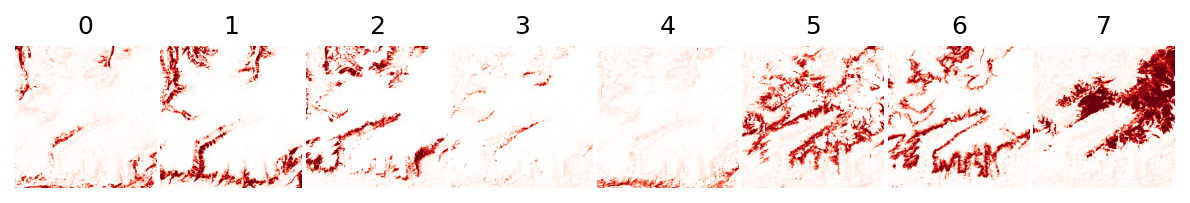

In [56]:
import numpy as np
from pyeumap.plotter import plot_rasters

lc_classes = [ int(c) for c in landmapper.target_classes['transformed']]

plot_rasters(*output_fn_files[0:8], cmaps='Reds', titles=lc_classes)

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


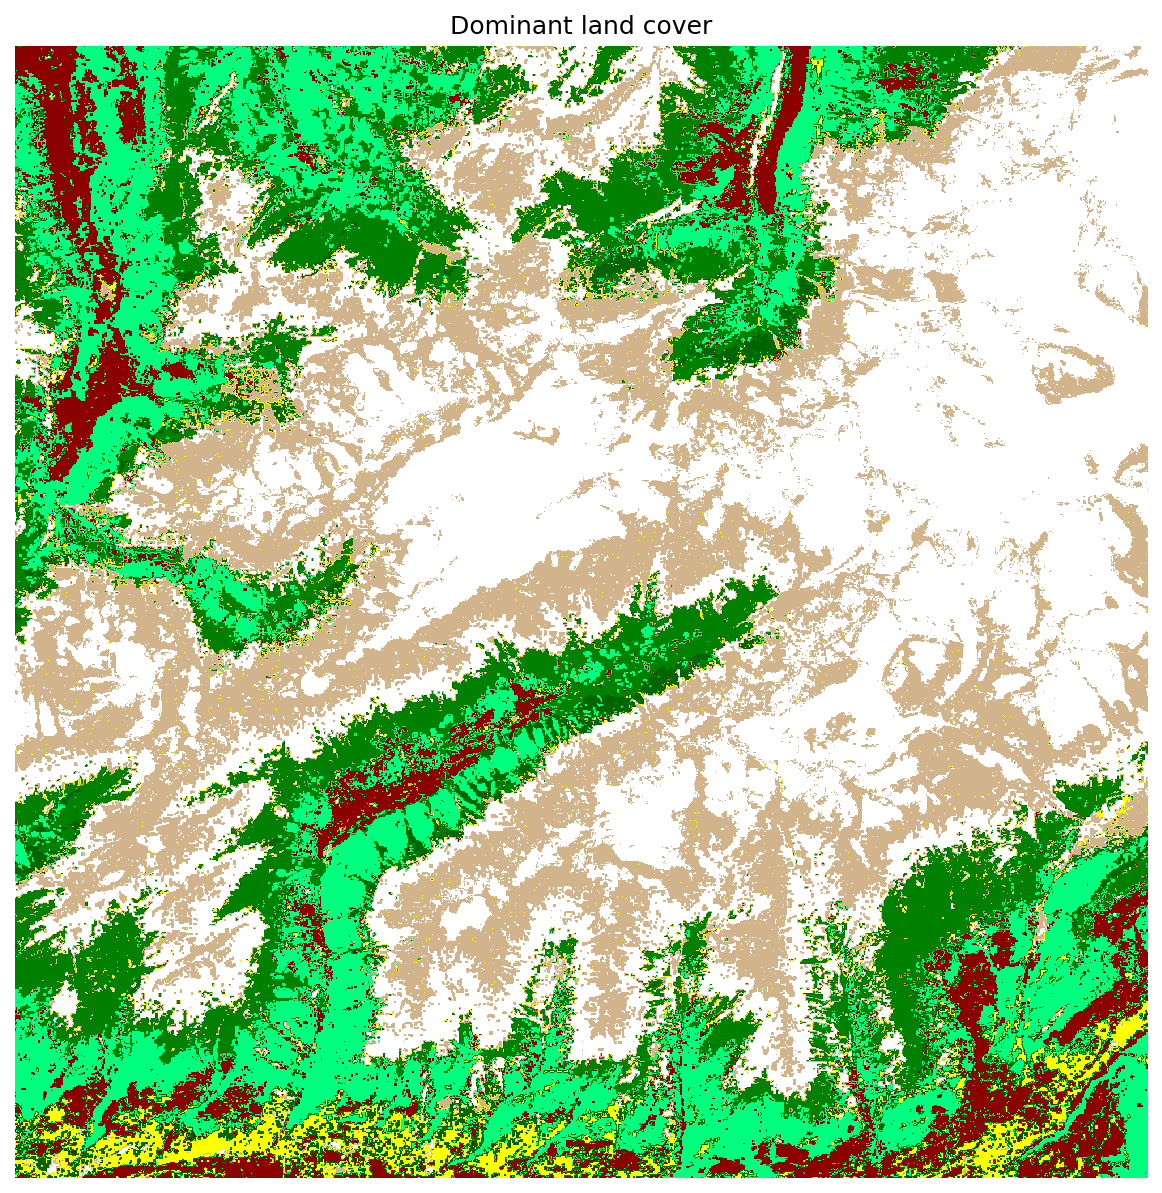

In [60]:
from pyeumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover')

Next, we will construct a voting classifier ensemble using [`scikit-learn`](https://scikit-learn.org) and train it.

In [ ]:
voting_ensemble = VotingClassifier([
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('gbt', GradientBoostingClassifier()),
], voting='soft')

landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    estimator=voting_ensemble,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

With our second ensemble model we will produce predictions over the sample tile, as well as a classification uncertainty estimate.

In [ ]:
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root, tile)

dir_timeless_layers = os.path.join(data_dir, 'timeless')
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_result = 'land_cover_2000.tif'
data_type = gdal.GDT_Int16

landmapper.predict(dirs_layers, fn_result, data_type, estimate_uncertainty=True)

Now we can visualize our predictions and uncertainty with the `pyeumap.plotter` module.

In [ ]:
from pyeumap import plotter

plotter.plot_rasters(
    'land_cover_2000.tif',
    'land_cover_2000_uncertainty.tif',
    cmaps=['Spectral', 'Reds'],
    figsize=6,
)

The image on the right represents classification uncertainty (ranging from 0 - white to 100 - red), expressed as relative entropy of the class predictions (the ratio of the prediction entropy to the maximum possible entropy for the given number of classes).